In [89]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim


TASK A

Binary image
   
Connected Component Extraction
   
Feature Extraction (shape descriptors)
   
Similarity Measurement
   
Clustering / Grouping (threshold-based)
   
Prototype Selection
   
Image Reconstruction
   
Threshold Variation & Observation


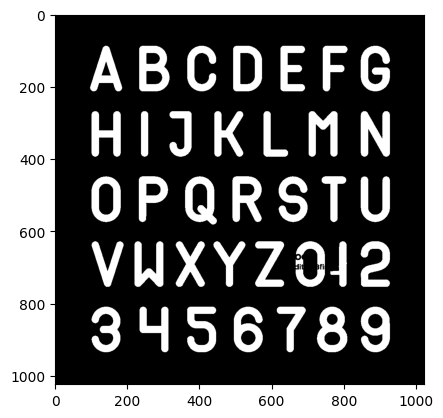

In [90]:
img = cv2.imread("document1.jpeg", cv2.IMREAD_GRAYSCALE)

# Convert to binary (text = white)
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

plt.imshow(binary, cmap='gray')
plt.show()

In [91]:
#Extract connected components (characters)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
#stats[i] gives:Area, Bounding box width & height
#Ignore label 0 (background)

In [92]:

characters = []
MIN_AREA = 50   # noise filter

for i in range(1, num_labels):  # skip background
    x, y, w, h, area = stats[i]

    if area < MIN_AREA:
        continue

    char_img = binary[y:y+h, x:x+w]

    characters.append({
        "bbox": (x, y, w, h),
        "img": char_img
    })


In [93]:
def pixel_iou(img1, img2, size=(32, 32)):
    i1 = cv2.resize(img1, size) > 0
    i2 = cv2.resize(img2, size) > 0

    inter = np.logical_and(i1, i2).sum()
    union = np.logical_or(i1, i2).sum()

    return inter / union if union != 0 else 0


In [94]:
def ssim_score(img1, img2, size=(32, 32)):
    i1 = cv2.resize(img1, size)
    i2 = cv2.resize(img2, size)
    return ssim(i1, i2, data_range=255)


In [99]:
def same_character(c1, c2, iou_th=0.60, ssim_th=0.60):
    iou = pixel_iou(c1["img"], c2["img"])
    ssim_val = ssim_score(c1["img"], c2["img"])
    return (iou >= iou_th) and (ssim_val >= ssim_th)


In [100]:
groups = []

for char in characters:
    placed = False

    for group in groups:
        rep = group[0]  # representative
        if same_character(char, rep):
            group.append(char)
            placed = True
            break

    if not placed:
        groups.append([char])


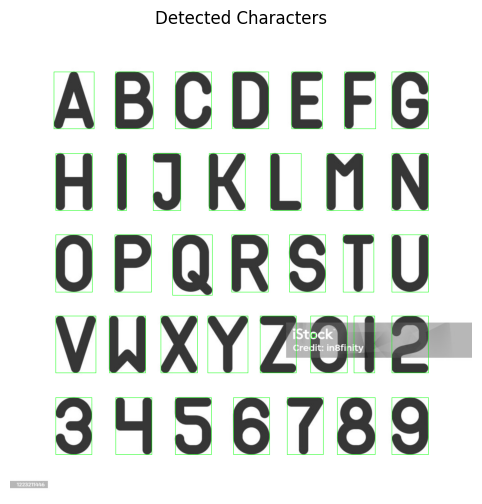

In [101]:
boxed = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for c in characters:
    x, y, w, h = c["bbox"]
    cv2.rectangle(boxed, (x, y), (x+w, y+h), (0,255,0), 1)

plt.figure(figsize=(8,6))
plt.title("Detected Characters")
plt.imshow(boxed, cmap="gray")
plt.axis("off")
plt.show()


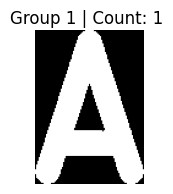

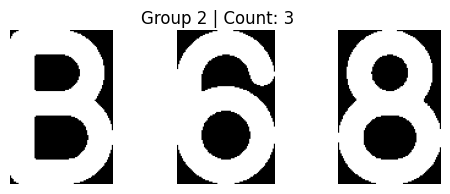

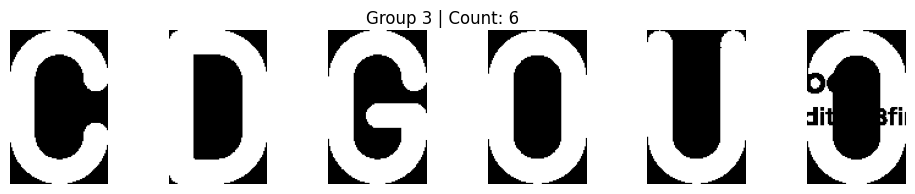

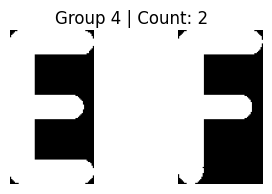

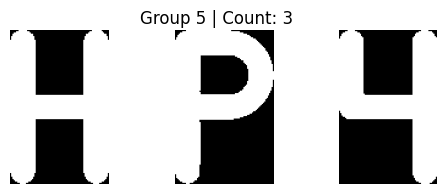

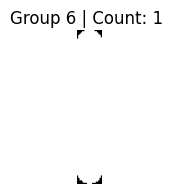

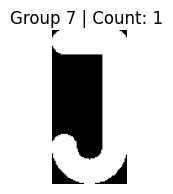

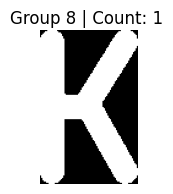

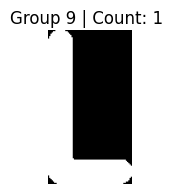

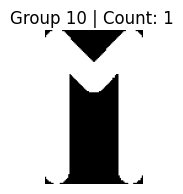

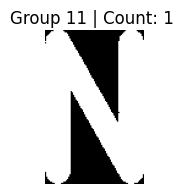

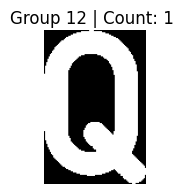

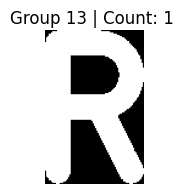

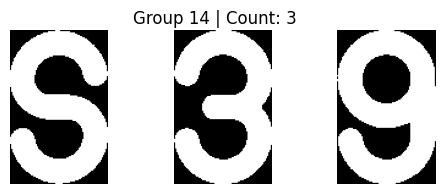

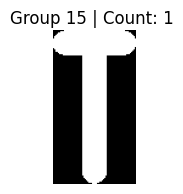

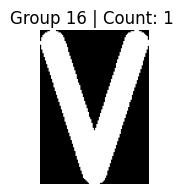

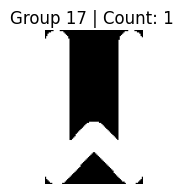

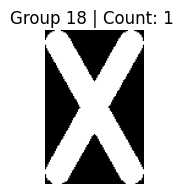

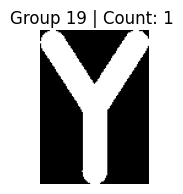

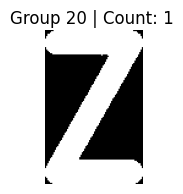

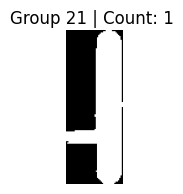

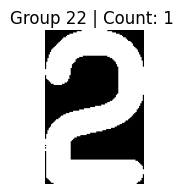

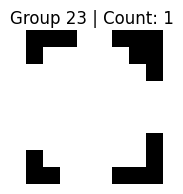

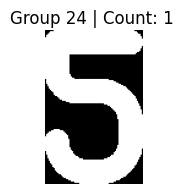

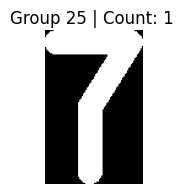

In [102]:
for idx, group in enumerate(groups):
    plt.figure(figsize=(len(group)*2, 2))
    plt.suptitle(f"Group {idx+1} | Count: {len(group)}")

    for i, char in enumerate(group):
        plt.subplot(1, len(group), i+1)
        plt.imshow(char["img"], cmap="gray")
        plt.axis("off")

    plt.show()


### TASK 2
#### Image with fine pattern
#### compute difference using psnr and ssim 
#### apply simple edge detecter or using ocr 
#### compare how metrics alg changes with compression

In [113]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Read grayscale image
img = cv2.imread("fine_pattern.jpg", cv2.IMREAD_GRAYSCALE)

qualities = [90, 70, 50, 30]

for q in qualities:
    # JPEG compression
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), q]
    _, enc = cv2.imencode(".jpg", img, encode_param)
    comp = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)

    # Metrics
    psnr = peak_signal_noise_ratio(img, comp)
    ssim = structural_similarity(img, comp)

    # Edge detection
    edges = cv2.Canny(comp, 100, 200)

    print(f"Quality={q} | PSNR={psnr:.2f} | SSIM={ssim:.2f}")



Quality=90 | PSNR=56.35 | SSIM=1.00
Quality=70 | PSNR=66.77 | SSIM=1.00
Quality=50 | PSNR=40.47 | SSIM=0.98
Quality=30 | PSNR=36.68 | SSIM=0.94


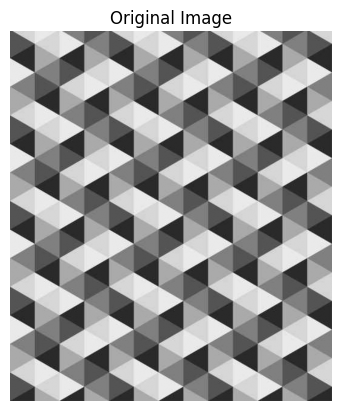

In [116]:
img = cv2.imread("fine_pattern.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

In [117]:
qualities = [95, 70, 40, 20]
compressed_images = {}

for q in qualities:
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), q]
    _, enc = cv2.imencode('.jpg', img, encode_param)
    dec = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)
    compressed_images[q] = dec

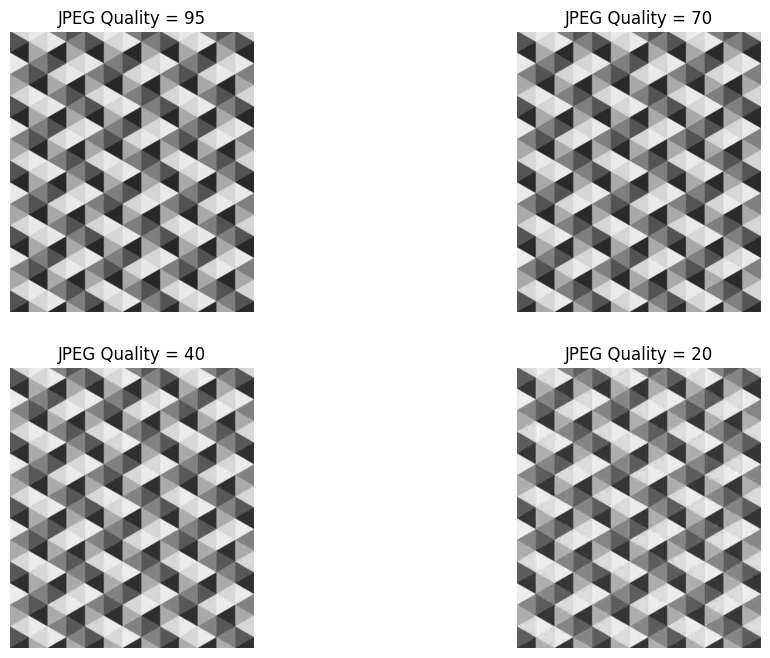

In [118]:
plt.figure(figsize=(12, 8))

for i, q in enumerate(qualities):
    plt.subplot(2, 2, i+1)
    plt.imshow(compressed_images[q], cmap='gray')
    plt.title(f"JPEG Quality = {q}")
    plt.axis('off')

plt.show()

In [119]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

print("Quality | PSNR | SSIM")
print("------------------------")

for q in qualities:
    p = psnr(img, compressed_images[q])
    s = ssim(img, compressed_images[q])
    print(f"{q:>7} | {p:.2f} | {s:.4f}")

Quality | PSNR | SSIM
------------------------
     95 | 59.14 | 0.9996
     70 | 66.77 | 1.0000
     40 | 37.27 | 0.9519
     20 | 34.87 | 0.9227


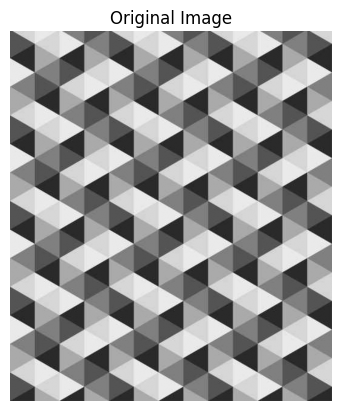

In [121]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("fine_pattern.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

### lossy compression using character prototypes
qualities = [95, 70, 40, 20]
jpeg_images = {}

for q in qualities:
    params = [int(cv2.IMWRITE_JPEG_QUALITY), q]
    _, enc = cv2.imencode('.jpeg', img, params)
    jpeg_images[q] = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)


In [122]:
### lossless compression using png 
png_params = [int(cv2.IMWRITE_PNG_COMPRESSION), 9]  # max compression
_, enc_png = cv2.imencode('.png', img, png_params)
png_img = cv2.imdecode(enc_png, cv2.IMREAD_GRAYSCALE)


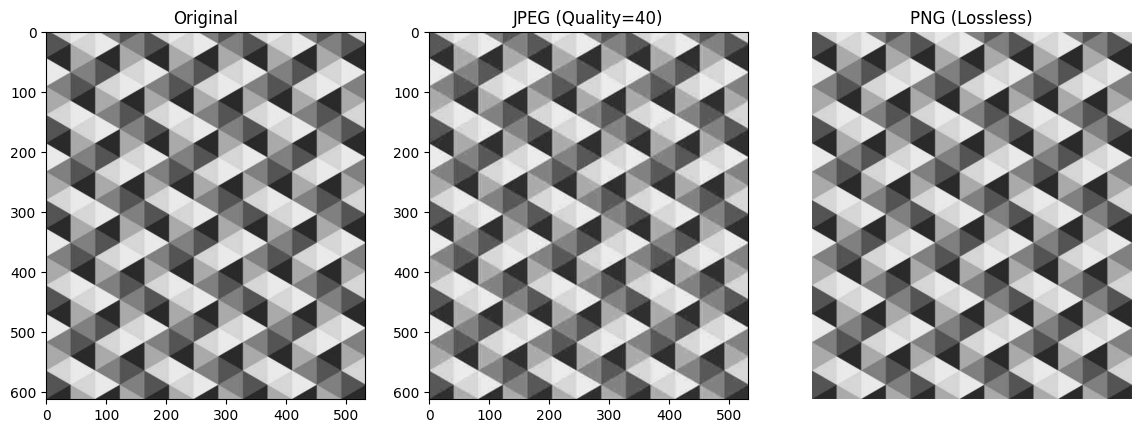

In [123]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(jpeg_images[40], cmap='gray')
plt.title("JPEG (Quality=40)")

plt.subplot(1, 3, 3)
plt.imshow(png_img, cmap='gray')
plt.title("PNG (Lossless)")

plt.axis('off')
plt.show()


In [124]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

print("Method        | PSNR   | SSIM")
print("-------------------------------")

for q in qualities:
    print(f"JPEG {q:<8} | {psnr(img, jpeg_images[q]):.2f} | {ssim(img, jpeg_images[q]):.4f}")

print(f"PNG Lossless | {psnr(img, png_img):.2f} | {ssim(img, png_img):.4f}")


Method        | PSNR   | SSIM
-------------------------------
JPEG 95       | 59.14 | 0.9996
JPEG 70       | 66.77 | 1.0000
JPEG 40       | 37.27 | 0.9519
JPEG 20       | 34.87 | 0.9227
PNG Lossless | inf | 1.0000


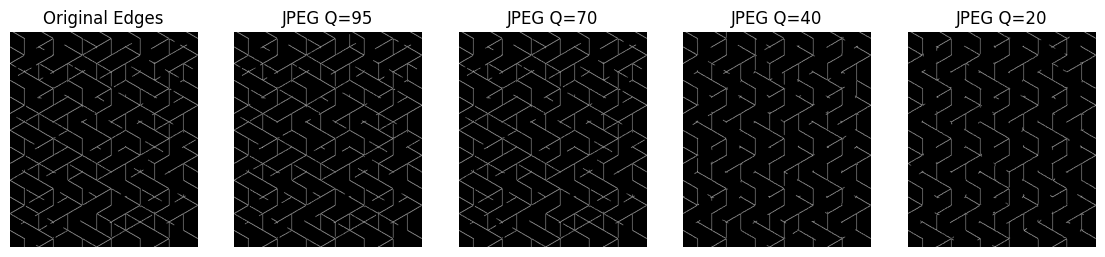

In [131]:
edges_original = cv2.Canny(img, 100, 200)
edges_compressed = []

for q in qualities:
    edges = cv2.Canny(jpeg_images[q], 100, 200)
    edges_compressed.append((q, edges))
plt.figure(figsize=(14, 6))
plt.subplot(1, len(qualities)+1, 1)
plt.imshow(edges_original, cmap='gray') 
plt.title("Original Edges")
plt.axis('off')
for i, (q, edges) in enumerate(edges_compressed):
    plt.subplot(1, len(qualities)+1, i+2)
    plt.imshow(edges, cmap='gray')
    plt.title(f"JPEG Q={q}")
    plt.axis('off')

### task 3
- scanned version of two doc that are same 
- one compressed using lossless method 
- one using lossy method 
- contouring the connected component 
- flag region where distortion 
- structural difference using shape discriptor or pixel comparision  

Number of distorted regions: 5971
Average distortion area: 53.12627700552671


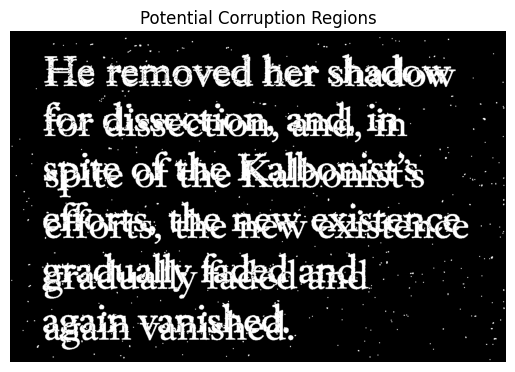

In [136]:
lossless = cv2.imread("lossless.png", cv2.IMREAD_GRAYSCALE) 

lossy = cv2.imread("lossy.png", cv2.IMREAD_GRAYSCALE) 

diff = cv2.absdiff(lossless, lossy) 

_, diff_bin = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY) 
num, labels, stats, _ = cv2.connectedComponentsWithStats(diff_bin, 8)

print("Number of distorted regions:", num - 1)

areas = stats[1:, cv2.CC_STAT_AREA]
print("Average distortion area:", np.mean(areas))

kernel = np.ones((3,3), np.uint8) 

diff_bin = cv2.morphologyEx(diff_bin, cv2.MORPH_OPEN, kernel) 

plt.imshow(diff_bin, cmap='gray') 

plt.title("Potential Corruption Regions") 

plt.axis("off") 

plt.show()

The text looks “overlapped” because you are seeing the difference between two versions of the same text where: edges have shifted slightly strokes became thicker or thinner blur caused character boundaries to move So both versions don’t match pixel-to-pixel, and the difference image highlights both edge positions, which looks like overlapping letters.

### task 4
- rule based character recognizer 
- 

Recognition accuracy after compression: 1.00


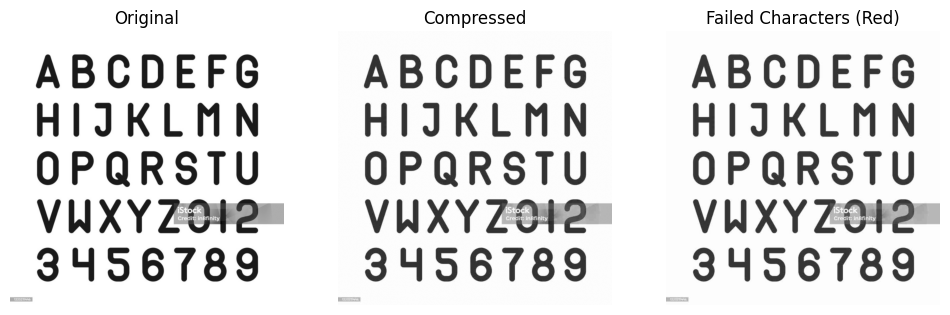

In [154]:

import cv2, numpy as np, matplotlib.pyplot as plt
from skimage.measure import label, regionprops

# -----------------------------
# 1. LOAD ORIGINAL IMAGE
# -----------------------------
img = cv2.imread("document1.jpeg", cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("Image not found")

# resize for consistency
img = cv2.resize(img, (900, 900))

# -----------------------------
# 2. CREATE COMPRESSED VERSION
# -----------------------------
params = [int(cv2.IMWRITE_JPEG_QUALITY), 20]   # heavy compression
_, enc = cv2.imencode(".jpg", img, params)
img_comp = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)

# -----------------------------
# 3. BINARIZATION
# -----------------------------
_, bin_orig = cv2.threshold(img, 0, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
_, bin_comp = cv2.threshold(img_comp, 0, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# -----------------------------
# 4. SIMPLE RULE-BASED CLASSIFIER
# -----------------------------
def simple_classifier(region):
    h, w = region.shape
    ratio = h / (w + 1e-5)

    if ratio > 2.5:
        return "1/I"
    elif ratio < 1.0:
        return "O/0"
    elif 1.2 < ratio < 1.8:
        return "E/F/H"
    else:
        return "OTHER"

# -----------------------------
# 5. CONNECTED COMPONENT ANALYSIS
# -----------------------------
def classify_image(bin_img):
    labels = label(bin_img)
    preds = []

    for r in regionprops(labels):
        if r.area < 200:   # remove noise
            continue
        region = bin_img[r.slice]
        pred = simple_classifier(region)
        preds.append((r.bbox, pred))
    return preds

pred_orig = classify_image(bin_orig)
pred_comp = classify_image(bin_comp)

# -----------------------------
# 6. ACCURACY MEASUREMENT
# -----------------------------
total = min(len(pred_orig), len(pred_comp))
correct = 0
failed_boxes = []

for i in range(total):
    if pred_orig[i][1] == pred_comp[i][1]:
        correct += 1
    else:
        failed_boxes.append(pred_comp[i][0])

accuracy = correct / total if total > 0 else 0
print(f"Recognition accuracy after compression: {accuracy:.2f}")

# -----------------------------
# 7. VISUALIZE FAILURES
# -----------------------------
vis = cv2.cvtColor(img_comp, cv2.COLOR_GRAY2BGR)

for (y0, x0, y1, x1) in failed_boxes:
    cv2.rectangle(vis, (x0, y0), (x1, y1), (0,0,255), 2)

plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Compressed")
plt.imshow(img_comp, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Failed Characters (Red)")
plt.imshow(vis, cmap="gray")
plt.axis("off")

plt.show()


### task 5 
- designing a safe heuristic to identify that image is lossley compresed, lossy compressed or not compressed 
- using entropy, edge density, or connected count as signal and it should work on different image as text, form, photos

In [1]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

In [2]:
def image_entropy(image):
    hist = np.histogram(image.flatten(), bins=256, range=(0,256))[0]
    prob = hist / hist.sum()
    prob = prob[prob > 0]
    return -np.sum(prob * np.log2(prob))

In [3]:
def edge_density(image):
    edges = cv2.Canny(image, 100, 200)
    return np.sum(edges > 0) / edges.size

In [4]:
def component_density(image):
    _, bin_img = cv2.threshold(image, 0, 255,
                               cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(bin_img) > 127:   # text usually dark
        bin_img = 255 - bin_img

    labels = label(bin_img)
    count = 0
    for r in regionprops(labels):
        if r.area > 50:
            count += 1
    return count / image.size

In [5]:
def compression_decision(image):

    e = image_entropy(image)
    d = edge_density(image)
    c = component_density(image)

    print(f"Entropy={e:.2f}, EdgeDensity={d:.3f}, CompDensity={c:.5f}")

    # Very sensitive documents
    if d > 0.18 and c > 0.0005:
        return "DO NOT COMPRESS (or use PNG/TIFF)"

    # Normal text / forms
    elif d > 0.10 or c > 0.0003:
        return "USE LOSSLESS COMPRESSION"

    # Photos or smooth images
    else:
        return "LOSSY COMPRESSION SAFE (JPEG)"

In [8]:
img_text  = cv2.imread("document.png",  cv2.IMREAD_GRAYSCALE)
img_form  = cv2.imread("digits.png",      cv2.IMREAD_GRAYSCALE)
img_photo = cv2.imread("fine_pattern.jpg",     cv2.IMREAD_GRAYSCALE)

print("Text Image:",  compression_decision(img_text))
print("Form Image:",  compression_decision(img_form))
print("Photo Image:", compression_decision(img_photo))

Entropy=1.57, EdgeDensity=0.076, CompDensity=0.00024
Text Image: LOSSY COMPRESSION SAFE (JPEG)
Entropy=0.17, EdgeDensity=0.006, CompDensity=0.00003
Form Image: LOSSY COMPRESSION SAFE (JPEG)
Entropy=5.35, EdgeDensity=0.045, CompDensity=0.00002
Photo Image: LOSSY COMPRESSION SAFE (JPEG)


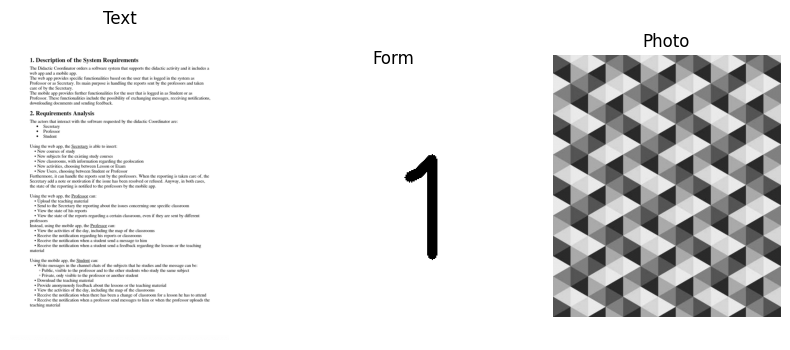

In [9]:
#optional 

plt.figure(figsize=(10,4))

plt.subplot(1,3,1); plt.imshow(img_text, cmap='gray');  plt.title("Text");  plt.axis('off')
plt.subplot(1,3,2); plt.imshow(img_form, cmap='gray');  plt.title("Form");  plt.axis('off')
plt.subplot(1,3,3); plt.imshow(img_photo, cmap='gray'); plt.title("Photo"); plt.axis('off')

plt.show()